<a href="https://colab.research.google.com/github/FGalvao77/Implementando-Redes-Generativas-Adversarias-GAN-do-ZERO-PyTorch-Deep-Learning/blob/main/01_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementando Redes Generativas Adversárias (GAN) do ZERO | PyTorch | Deep Learning**

---



In [ ]:
# importando as bibliotecas e as funções necessárias
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn,  optim
from IPython import display

In [ ]:
# definindo as configurações para uso das imagens
imgsize = 28        # resolução da imagem
batch_size = 128    # quantidade do agupamentos das imagens

In [ ]:
# criando diretórios no google drive para salvar o conjunto de dados das imagens
DATA_DIR = '/content/drive/MyDrive/PrimeiraGAN'     # pasta para salvar o conjunto de dados das imagens
IMG_DIR = os.path.join(DATA_DIR, 'results')         # para salvar as imagens geradas pelo modelo

In [ ]:
# instanciando o transformador das imagens
fashion_transform = transforms.Compose(
    [transforms.ToTensor(), # convertendo para tensor
     transforms.Normalize(
         (0.5), (0.5))  # normalizando as imagens - com média de 0.5 e desvio padrão de 0.5
    ]
)

# instanciando o conjunto de dados na variável "fashion_data"
# passando como argumentos o diretório onde foi realizado o download das imagens,
# o transformador e download recebe True
fashion_data = datasets.FashionMNIST(DATA_DIR, 
                                     transform=fashion_transform,
                                     download=True)

# instanciando o objeto que irá iterar as imagens
# passando como argumentos a variável "fashion_data"
# o tamanho dos agrupamentos
# e a função "shuffle=True" para embaralhar as imagens
dataloader = DataLoader(fashion_data, 
                        batch_size=batch_size, 
                        shuffle=True)

In [ ]:
# instanciando a primeira imagem e seu rótulo para visualizarmos
img, label = fashion_data[0]

In [ ]:
# visualizando a imagem
img

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

> Veja que a imagem em questão é um tensor!

In [ ]:
# visualizando o rótulo da imagem
label

9

In [ ]:
# visualizando a quantidade de imagens
len(fashion_data)

60000

In [ ]:
# visualizando o tipo do objeto
type(fashion_data)

torchvision.datasets.mnist.FashionMNIST

In [ ]:
# criando uma função para auxiliar na visualização das imagens
def lookat_dataset(dataset, pilimg=False):
    figure = plt.figure(figsize=[16, 4])    # tamanho das imagens
    rows, cols = 2, 8   # 2 linhas por 8 colunas, toatalizando 16 imagens

    # realizando um laço de repetição de 1 até 17
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset),    # visualizando as imagens aleatórias
                                   size=(1,)).item()

        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis('off')

        if pilimg:
            plt.imshow(img)
        else:
            img = (img.squeeze() * 0.5) + 0.5

            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')    # imagens no tons de cinza
            else:
                plt.imshow(img.permute(1, 2, 0))

    plt.show();

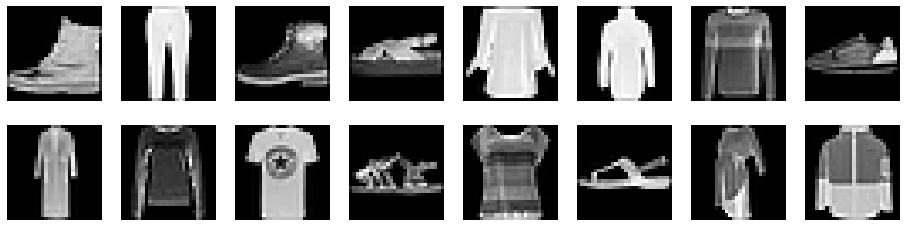

In [ ]:
# visualizando as imagens
lookat_dataset(fashion_data)

In [ ]:
# arquitetura da rede neural

# instanciando o gerador
class Generator(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 256),
            nn.LeakyReLU(),     # função de ativação

            nn.Linear(256, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 1024),
            nn.LeakyReLU(),

            nn.Linear(1024, n_output),
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)

# instanciando o discriminador
class Discriminator(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        n_output = 1

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 1024),
            nn.LeakyReLU(0.2),      # função de ativação
       
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
        
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
     
            nn.Linear(256, n_output),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        return self.layers(x)

In [ ]:
# instanciando o ambiente que está rodando a rede neural
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [ ]:
# instaciando a dimensão do ruído
noise_dim = 100

# instanciando o gerador com a dimensão do ruído e o tamanho das imagens
generator = Generator(noise_dim, 
                      imgsize * imgsize).to(device)
                      
discriminator = Discriminator(imgsize * imgsize).to(device)

In [ ]:
# função para transformar as imagens em vetores
def images_to_vectors(images):
    return images.view(images.size(0), 
                       imgsize * imgsize)

# função para transformar os vetores para imagens  
def vectors_to_images(vectors, nc=1):
    return vectors.view(vectors.size(0), 
                        nc, imgsize, imgsize)

# função para gerar ruídos
def noise(size, dim=noise_dim, device=device):
    return torch.randn(size, 
                       dim).to(device)

# função para visualizar as imagens
def log_images(test_images, savepath=None):
    figure = plt.figure(figsize=[8, 8])
    figure.subplots_adjust(wspace=0.08,
                           hspace=0.01)
    
    rows, cols = len(test_images) // 4, 4

    for i, img in enumerate(test_images):
        figure.add_subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(img.squeeze(), 
                   cmap='gray')

    if savepath is not None:   
        figure.savefig(savepath)

    plt.show();

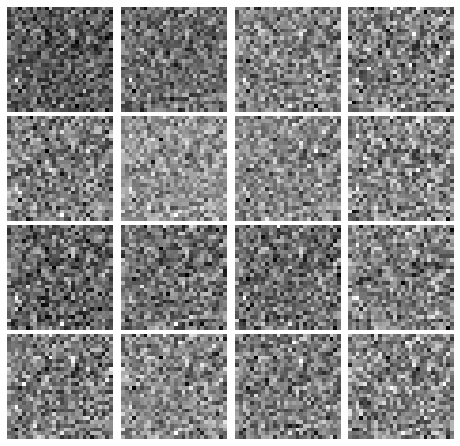

In [ ]:
# tamanho das amostras
num_test_samples = 16

# definindo a semente do modelo
torch.manual_seed(7777)

# instanciando o ruído do teste
test_noise = noise(num_test_samples,
                   noise_dim)

# salvando as imagens na pasta
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')

# realizando a visualização da imagem
log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(), 
        imagepath
)

In [ ]:
# função para rótulo dos dados reais
def real_data_target(size, device=device):
    return torch.ones(size, 1).to(device)

# função para rótulo dos dados falsos
def fake_data_target(size, device=device):
    return torch.zeros(size, 1).to(device)

In [ ]:
# taxa de aprendizagem
lr = 0.0002

# otimizador do gerador
g_optimizer = optim.Adam(generator.parameters(), 
                         lr = lr)

# otimizador do discriminador
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr = lr)

# função para cálculo do erro
loss = nn.BCELoss()

In [ ]:
# função para treinar o gerador
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    pred = discriminator(fake_data)

    error = loss(
        pred,
        real_data_target(pred.size(0)))
    error.backward()
    
    optimizer.step()

    return error

# função para treinar o gerador
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()

    pred_real = discriminator(real_data)
    error_real = loss(pred_real, 
                      real_data_target(real_data.size(0)))
    
    error_real.backward()

    pred_fake = discriminator(fake_data)
    error_fake = loss(pred_fake, 
                      fake_data_target(fake_data.size(0)))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, pred_real, pred_fake

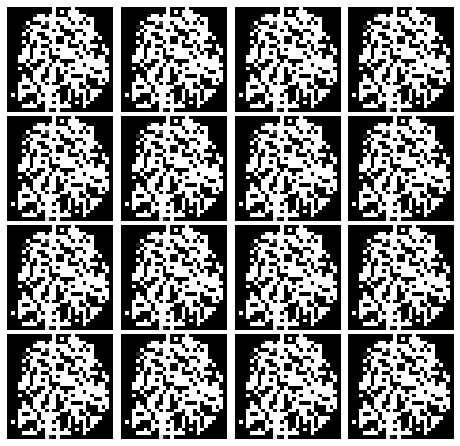

Epoch: 0 / 100 Losses: 
Discriminator: 0.0002 | Generator 8.8406
D(x): 0.9999 | D(G(z)): 0.0002


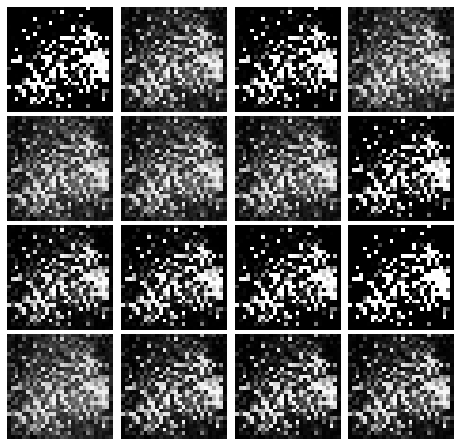

Epoch: 1 / 100 Losses: 
Discriminator: 0.0122 | Generator 10.1241
D(x): 0.9965 | D(G(z)): 0.0082


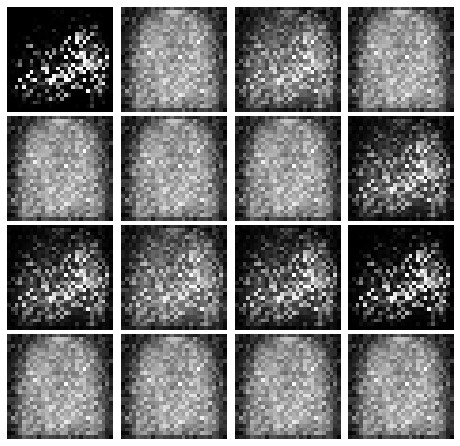

Epoch: 2 / 100 Losses: 
Discriminator: 0.2600 | Generator 10.5958
D(x): 0.9536 | D(G(z)): 0.0204


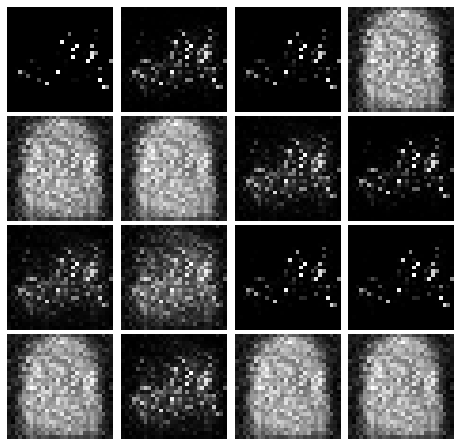

Epoch: 3 / 100 Losses: 
Discriminator: 0.0457 | Generator 6.0019
D(x): 0.9861 | D(G(z)): 0.0149


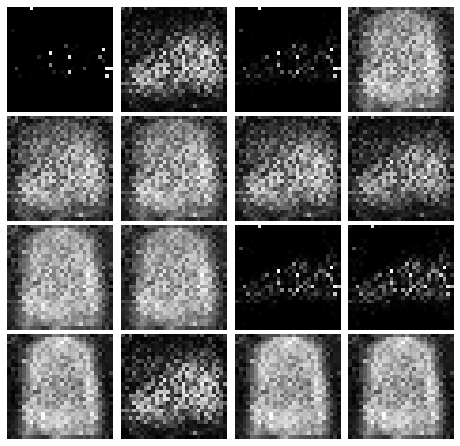

Epoch: 4 / 100 Losses: 
Discriminator: 0.1667 | Generator 4.5872
D(x): 0.9354 | D(G(z)): 0.0326


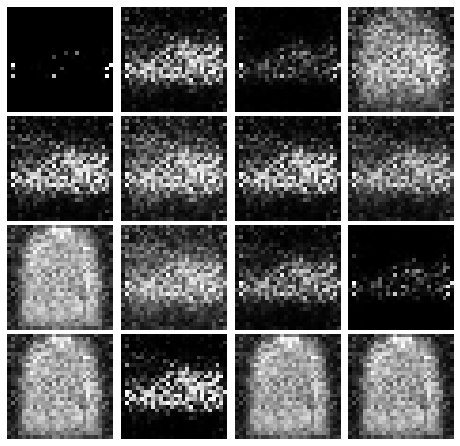

Epoch: 5 / 100 Losses: 
Discriminator: 0.1597 | Generator 4.7410
D(x): 0.9686 | D(G(z)): 0.0161


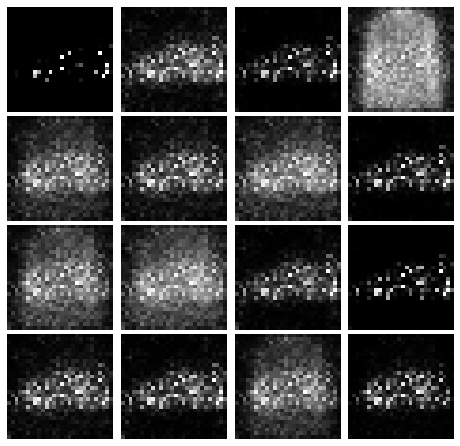

Epoch: 6 / 100 Losses: 
Discriminator: 0.0715 | Generator 6.6229
D(x): 0.9894 | D(G(z)): 0.0247


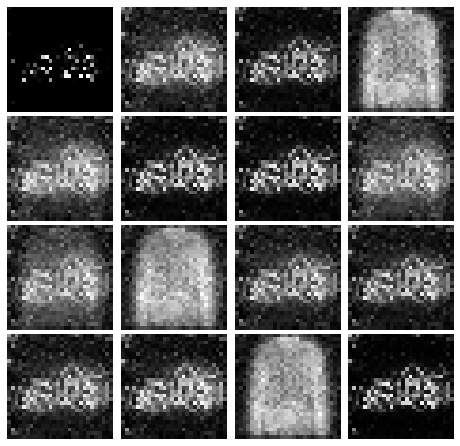

Epoch: 7 / 100 Losses: 
Discriminator: 0.0756 | Generator 5.5495
D(x): 0.9854 | D(G(z)): 0.0456


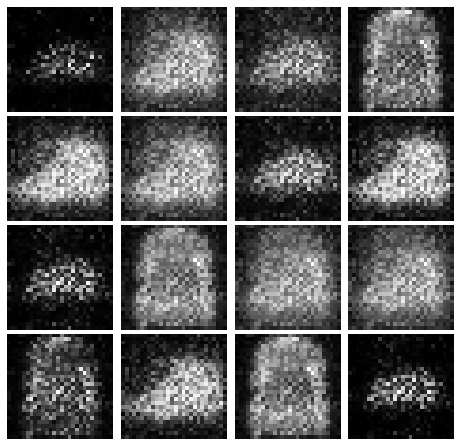

Epoch: 8 / 100 Losses: 
Discriminator: 0.1886 | Generator 5.2722
D(x): 0.9361 | D(G(z)): 0.0301


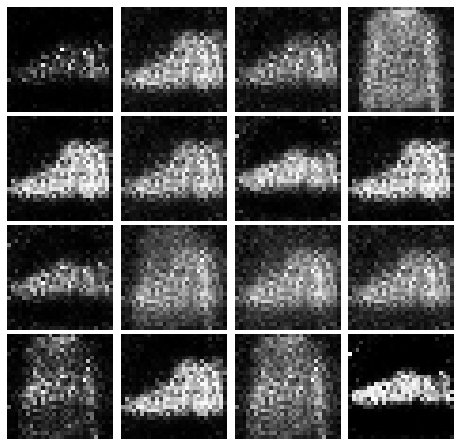

Epoch: 9 / 100 Losses: 
Discriminator: 0.1265 | Generator 6.1498
D(x): 0.9584 | D(G(z)): 0.0292


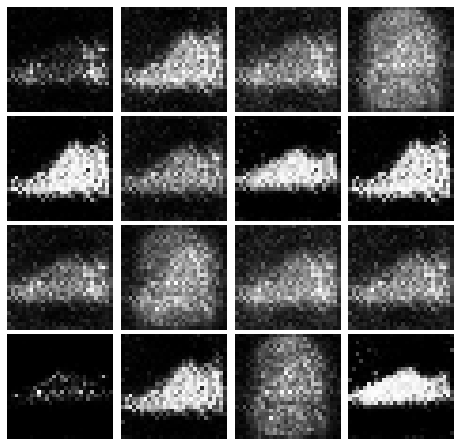

Epoch: 10 / 100 Losses: 
Discriminator: 0.3826 | Generator 3.9060
D(x): 0.8972 | D(G(z)): 0.0615


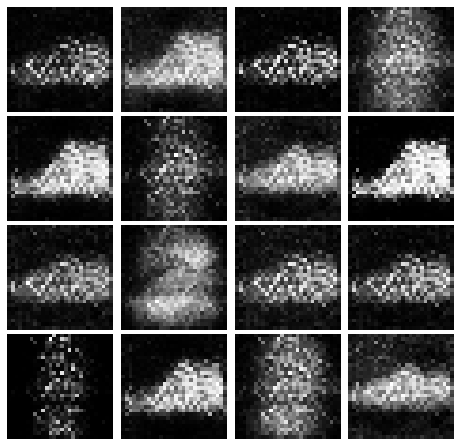

Epoch: 11 / 100 Losses: 
Discriminator: 0.2876 | Generator 3.5290
D(x): 0.9052 | D(G(z)): 0.0445


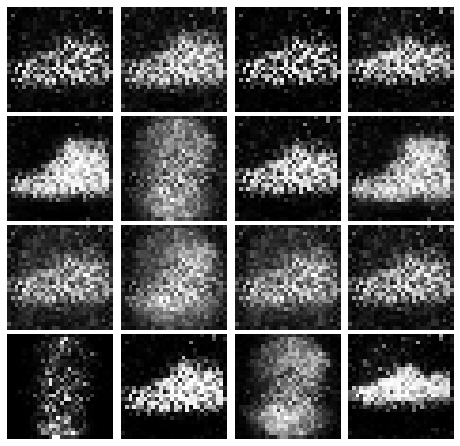

Epoch: 12 / 100 Losses: 
Discriminator: 0.1388 | Generator 3.9289
D(x): 0.9704 | D(G(z)): 0.0642


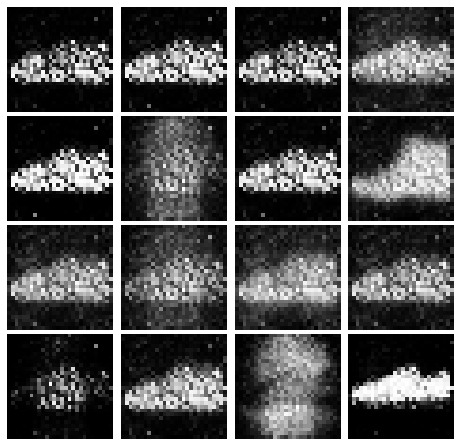

Epoch: 13 / 100 Losses: 
Discriminator: 0.1682 | Generator 3.8909
D(x): 0.9534 | D(G(z)): 0.0483


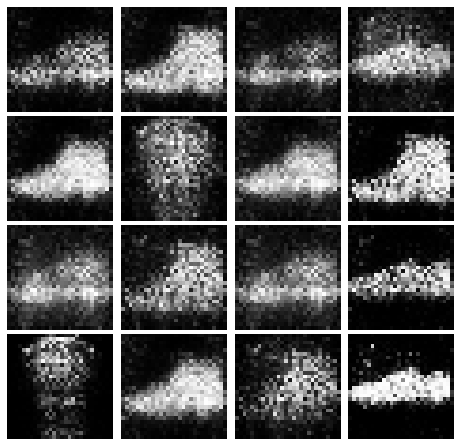

Epoch: 14 / 100 Losses: 
Discriminator: 0.3335 | Generator 3.0761
D(x): 0.8836 | D(G(z)): 0.0372


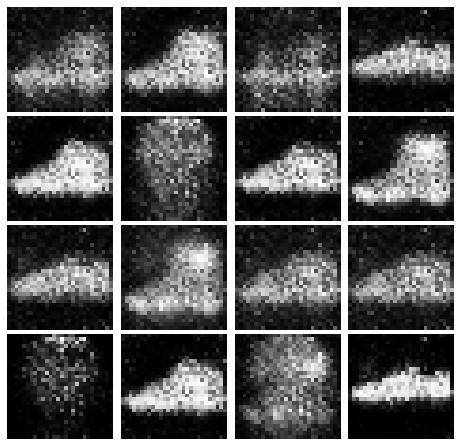

Epoch: 15 / 100 Losses: 
Discriminator: 0.3736 | Generator 4.5188
D(x): 0.9207 | D(G(z)): 0.1092


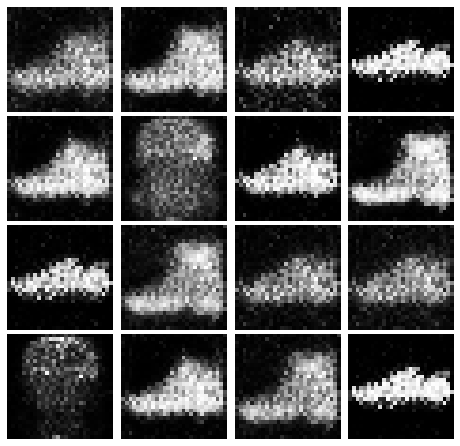

Epoch: 16 / 100 Losses: 
Discriminator: 0.2367 | Generator 4.1096
D(x): 0.9213 | D(G(z)): 0.0806


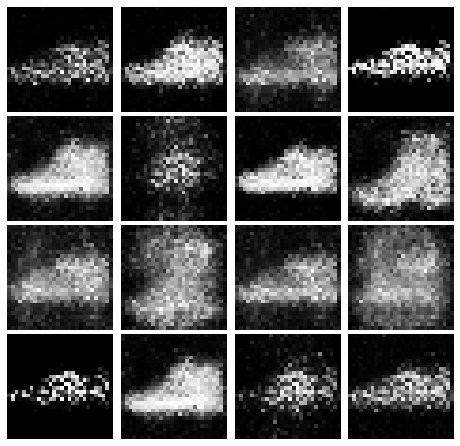

Epoch: 17 / 100 Losses: 
Discriminator: 0.3928 | Generator 4.7200
D(x): 0.8736 | D(G(z)): 0.0535


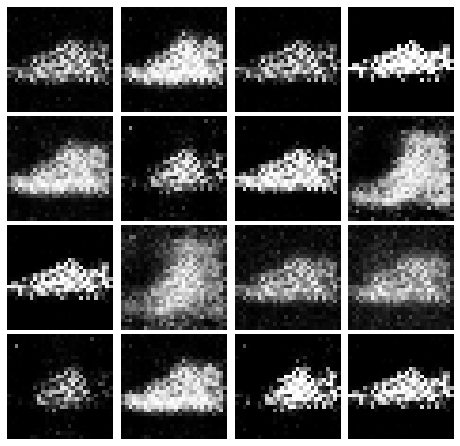

Epoch: 18 / 100 Losses: 
Discriminator: 0.3011 | Generator 3.9099
D(x): 0.9361 | D(G(z)): 0.0865


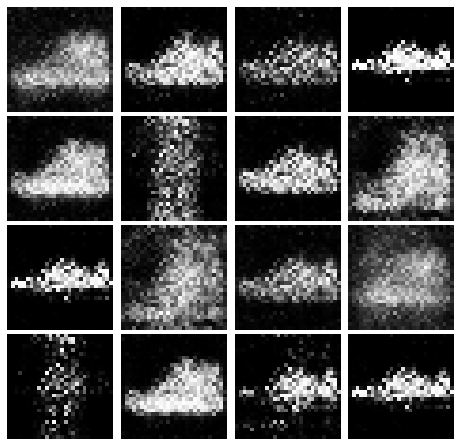

Epoch: 19 / 100 Losses: 
Discriminator: 0.2519 | Generator 3.8810
D(x): 0.9359 | D(G(z)): 0.1059


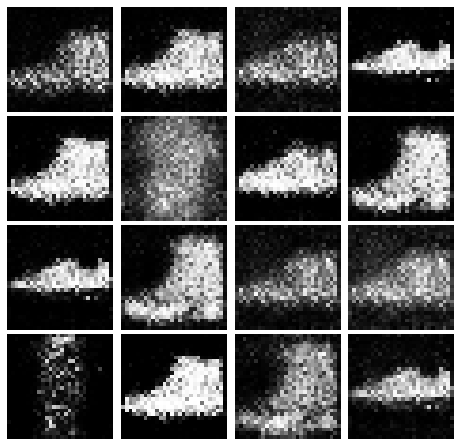

Epoch: 20 / 100 Losses: 
Discriminator: 0.2732 | Generator 3.4523
D(x): 0.9009 | D(G(z)): 0.0790


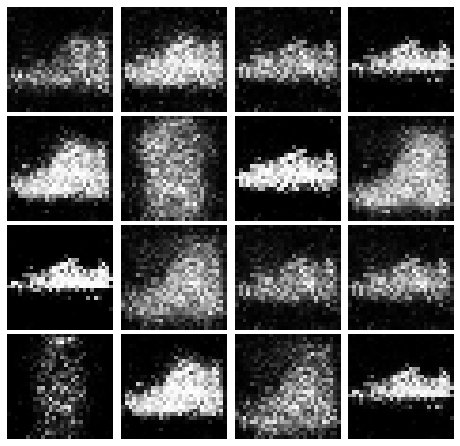

Epoch: 21 / 100 Losses: 
Discriminator: 0.2205 | Generator 4.8569
D(x): 0.9348 | D(G(z)): 0.0548


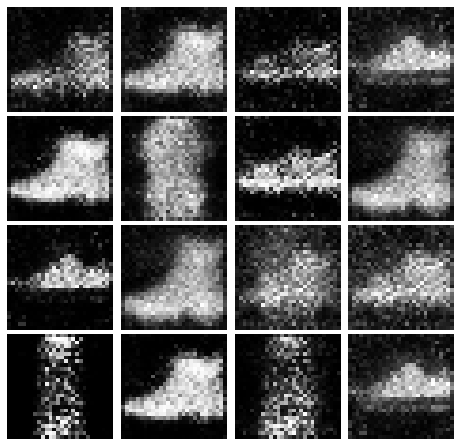

Epoch: 22 / 100 Losses: 
Discriminator: 0.2793 | Generator 2.6207
D(x): 0.8848 | D(G(z)): 0.0938


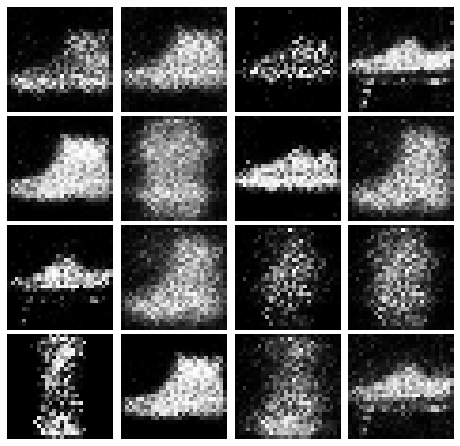

Epoch: 23 / 100 Losses: 
Discriminator: 0.2551 | Generator 4.3867
D(x): 0.8802 | D(G(z)): 0.0411


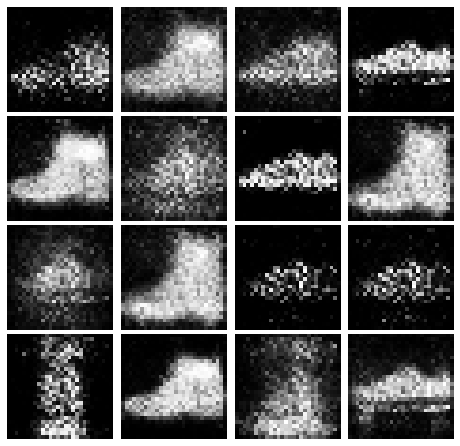

Epoch: 24 / 100 Losses: 
Discriminator: 0.6680 | Generator 2.6019
D(x): 0.8789 | D(G(z)): 0.2673


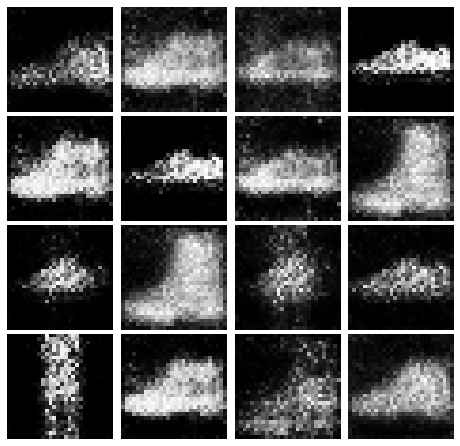

Epoch: 25 / 100 Losses: 
Discriminator: 0.6062 | Generator 2.7887
D(x): 0.8469 | D(G(z)): 0.1706


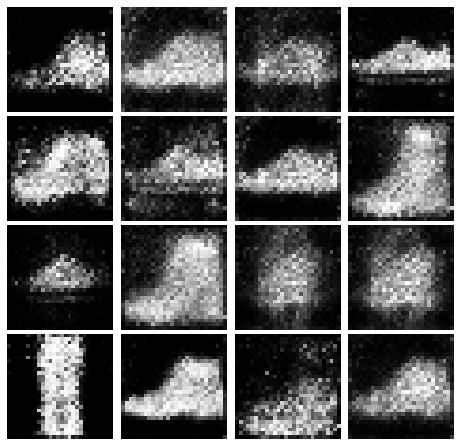

Epoch: 26 / 100 Losses: 
Discriminator: 0.5537 | Generator 2.4299
D(x): 0.8018 | D(G(z)): 0.1466


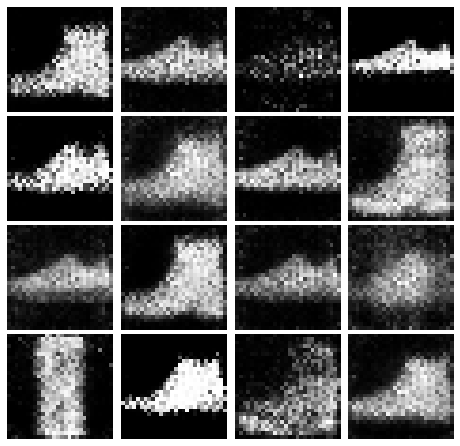

Epoch: 27 / 100 Losses: 
Discriminator: 0.3077 | Generator 4.7412
D(x): 0.9241 | D(G(z)): 0.1336


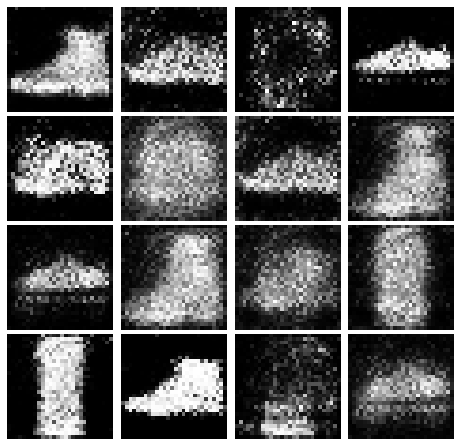

Epoch: 28 / 100 Losses: 
Discriminator: 0.4079 | Generator 3.2387
D(x): 0.9234 | D(G(z)): 0.1856


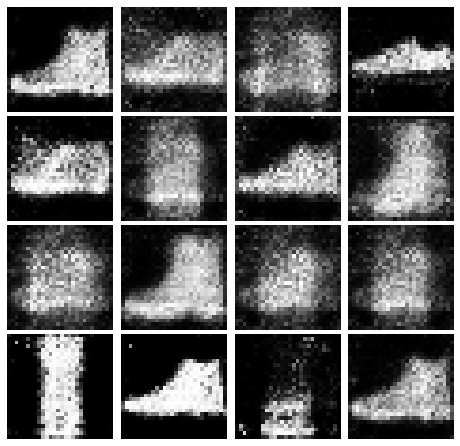

Epoch: 29 / 100 Losses: 
Discriminator: 0.7757 | Generator 1.7215
D(x): 0.7906 | D(G(z)): 0.1720


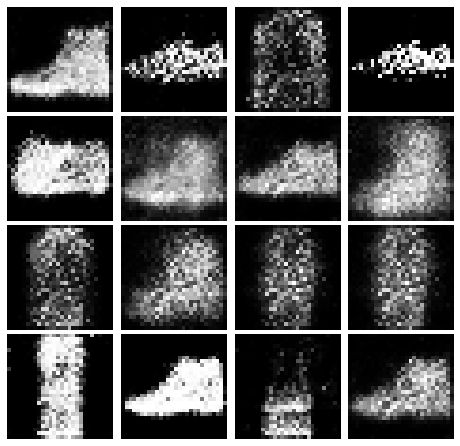

Epoch: 30 / 100 Losses: 
Discriminator: 0.4395 | Generator 3.9459
D(x): 0.8787 | D(G(z)): 0.1937


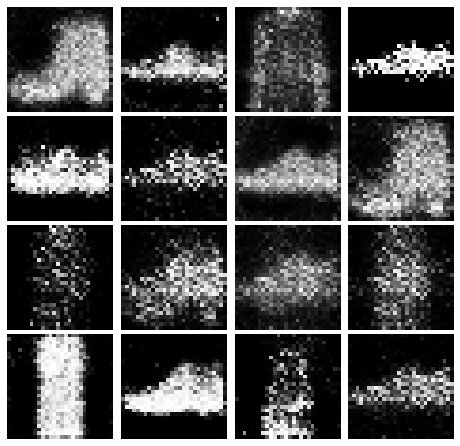

Epoch: 31 / 100 Losses: 
Discriminator: 0.4541 | Generator 2.8746
D(x): 0.8740 | D(G(z)): 0.1760


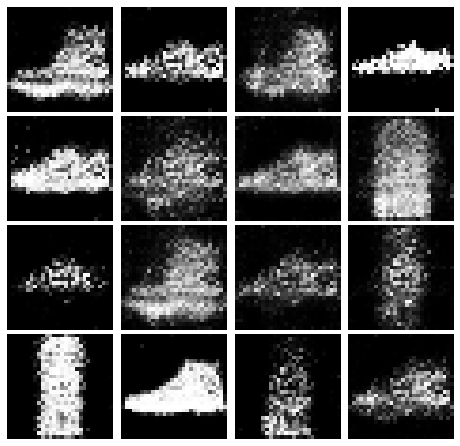

Epoch: 32 / 100 Losses: 
Discriminator: 0.5432 | Generator 1.9718
D(x): 0.8449 | D(G(z)): 0.1970


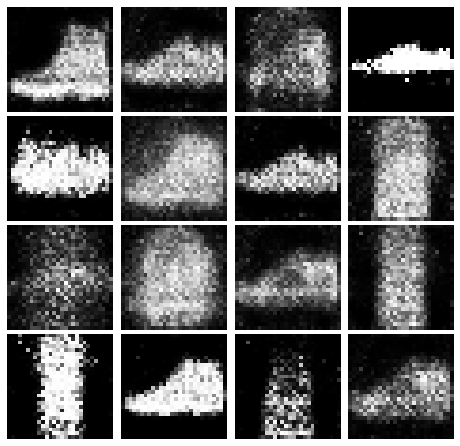

Epoch: 33 / 100 Losses: 
Discriminator: 0.4570 | Generator 2.8061
D(x): 0.8704 | D(G(z)): 0.2230


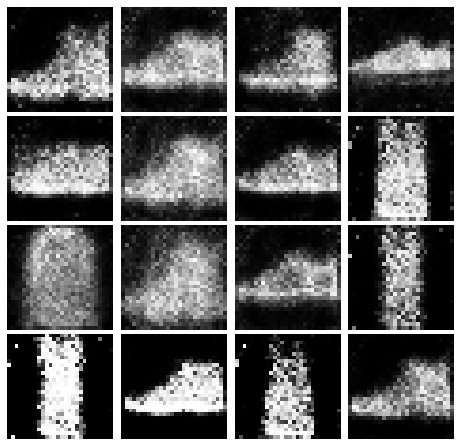

Epoch: 34 / 100 Losses: 
Discriminator: 0.5837 | Generator 3.1107
D(x): 0.8113 | D(G(z)): 0.1614


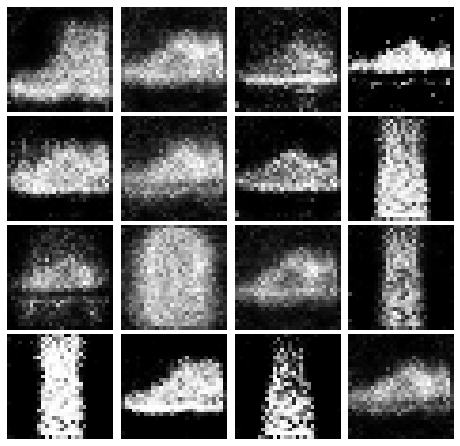

Epoch: 35 / 100 Losses: 
Discriminator: 0.6287 | Generator 2.1717
D(x): 0.7968 | D(G(z)): 0.1757


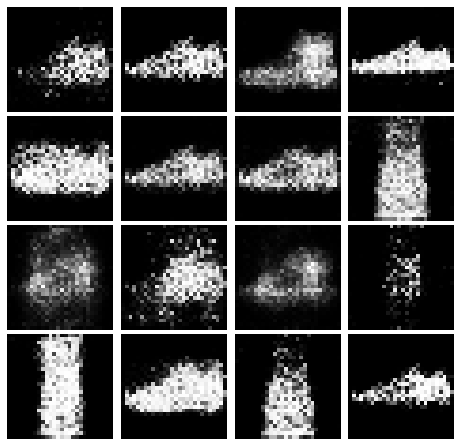

Epoch: 36 / 100 Losses: 
Discriminator: 0.8483 | Generator 3.6182
D(x): 0.7921 | D(G(z)): 0.1243


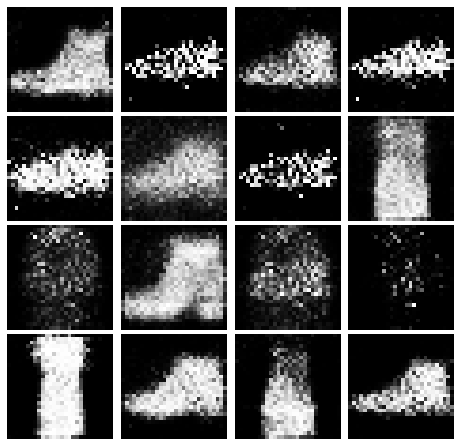

Epoch: 37 / 100 Losses: 
Discriminator: 0.4327 | Generator 2.8137
D(x): 0.8877 | D(G(z)): 0.2055


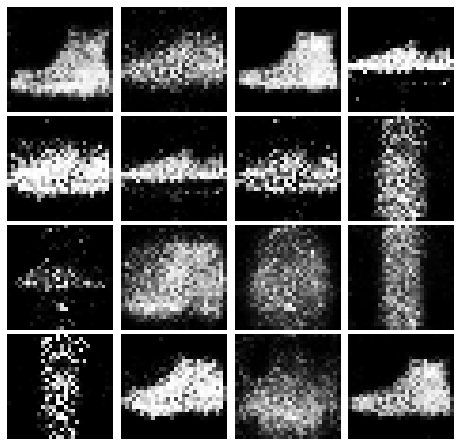

Epoch: 38 / 100 Losses: 
Discriminator: 0.1422 | Generator 4.2804
D(x): 0.9462 | D(G(z)): 0.0471


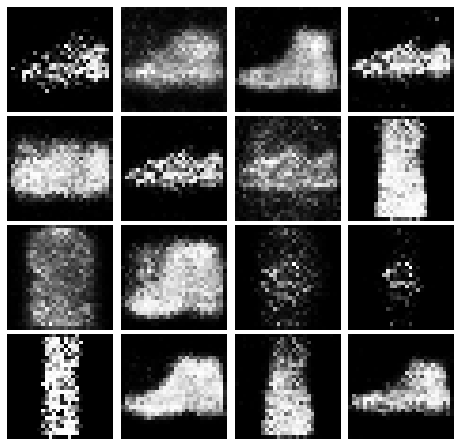

Epoch: 39 / 100 Losses: 
Discriminator: 0.9636 | Generator 2.0699
D(x): 0.7855 | D(G(z)): 0.3107


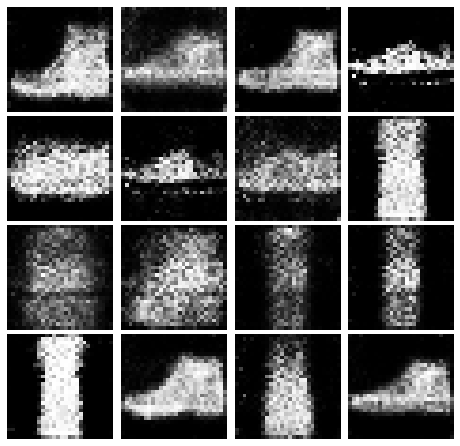

Epoch: 40 / 100 Losses: 
Discriminator: 0.4131 | Generator 2.9895
D(x): 0.8438 | D(G(z)): 0.1072


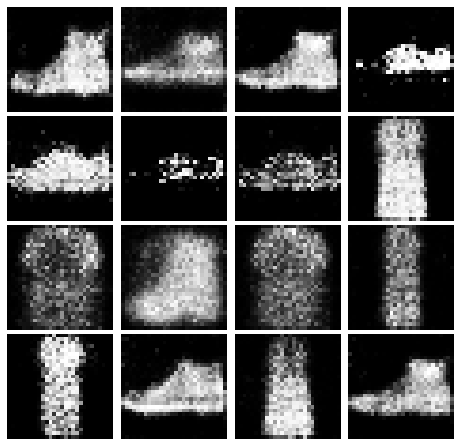

Epoch: 41 / 100 Losses: 
Discriminator: 0.7100 | Generator 1.7155
D(x): 0.8288 | D(G(z)): 0.3134


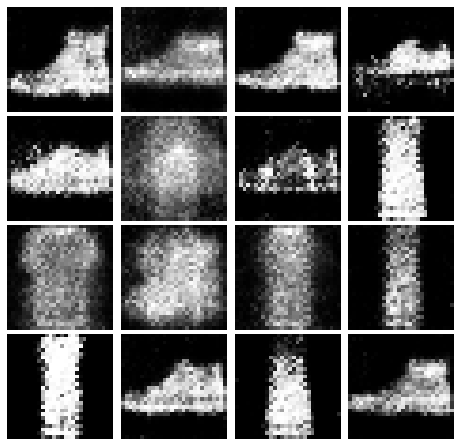

Epoch: 42 / 100 Losses: 
Discriminator: 0.6622 | Generator 2.2913
D(x): 0.8331 | D(G(z)): 0.2581


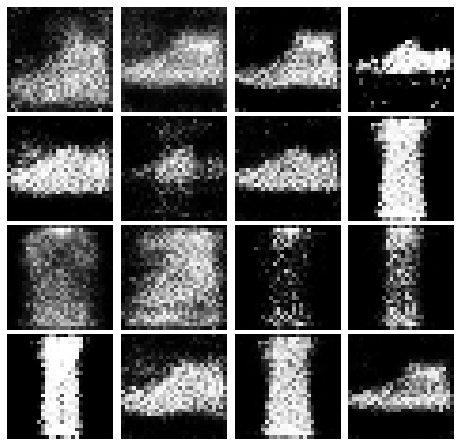

Epoch: 43 / 100 Losses: 
Discriminator: 0.8501 | Generator 3.1799
D(x): 0.7648 | D(G(z)): 0.1911


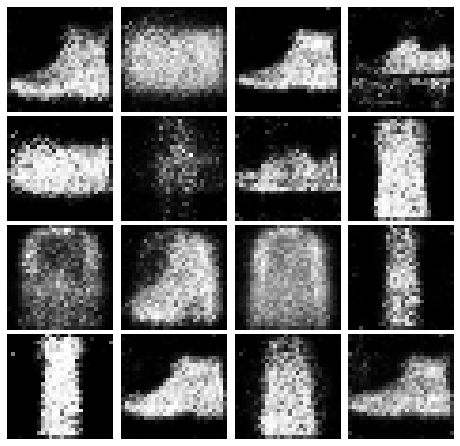

Epoch: 44 / 100 Losses: 
Discriminator: 0.4515 | Generator 3.1383
D(x): 0.8358 | D(G(z)): 0.1582


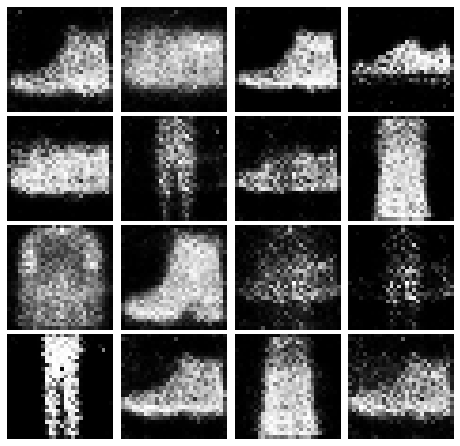

Epoch: 45 / 100 Losses: 
Discriminator: 0.5408 | Generator 3.8404
D(x): 0.7928 | D(G(z)): 0.0744


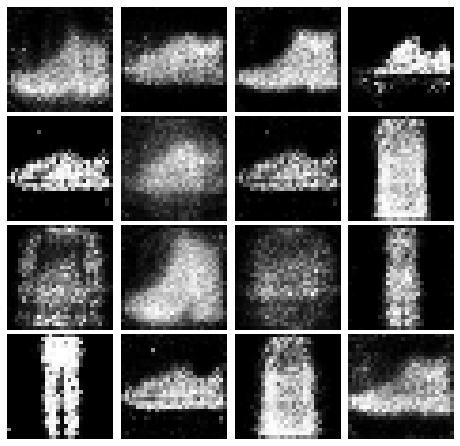

Epoch: 46 / 100 Losses: 
Discriminator: 0.4858 | Generator 2.1815
D(x): 0.8548 | D(G(z)): 0.1919


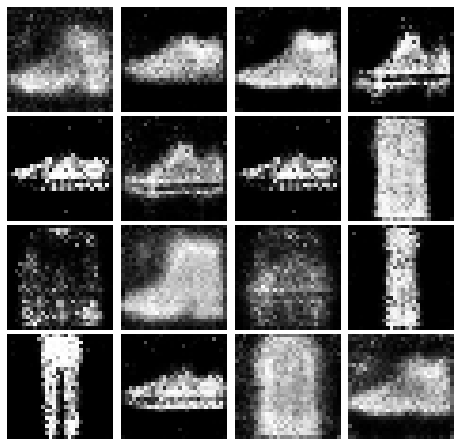

Epoch: 47 / 100 Losses: 
Discriminator: 0.6937 | Generator 2.2548
D(x): 0.8641 | D(G(z)): 0.3142


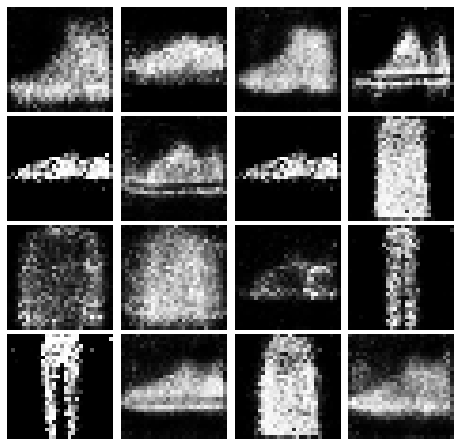

Epoch: 48 / 100 Losses: 
Discriminator: 0.5907 | Generator 2.4392
D(x): 0.8775 | D(G(z)): 0.2351


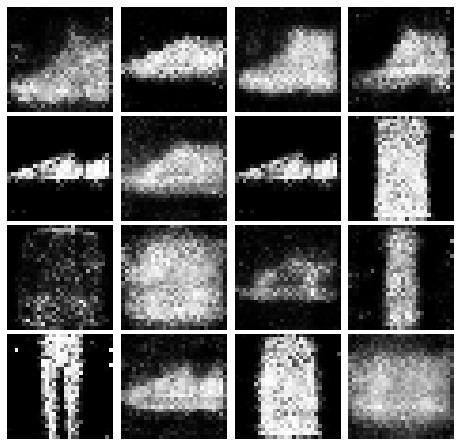

Epoch: 49 / 100 Losses: 
Discriminator: 0.4239 | Generator 3.7775
D(x): 0.8520 | D(G(z)): 0.0551


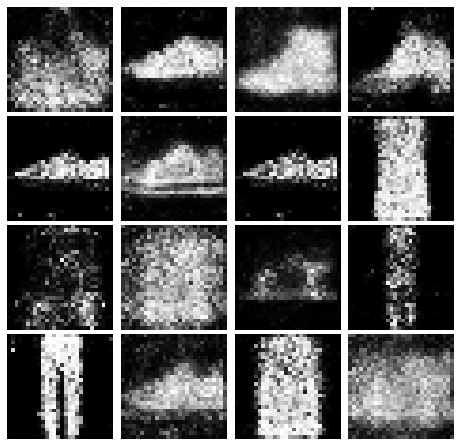

Epoch: 50 / 100 Losses: 
Discriminator: 0.6169 | Generator 2.5910
D(x): 0.8253 | D(G(z)): 0.1912


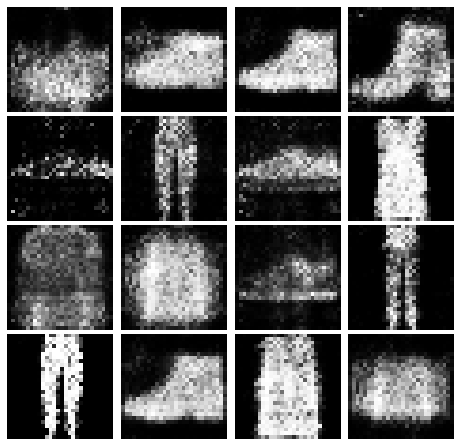

Epoch: 51 / 100 Losses: 
Discriminator: 0.6675 | Generator 8.8578
D(x): 0.8009 | D(G(z)): 0.0649


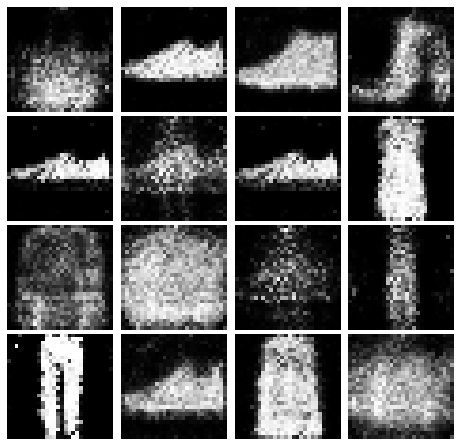

Epoch: 52 / 100 Losses: 
Discriminator: 0.3989 | Generator 2.6235
D(x): 0.8806 | D(G(z)): 0.1637


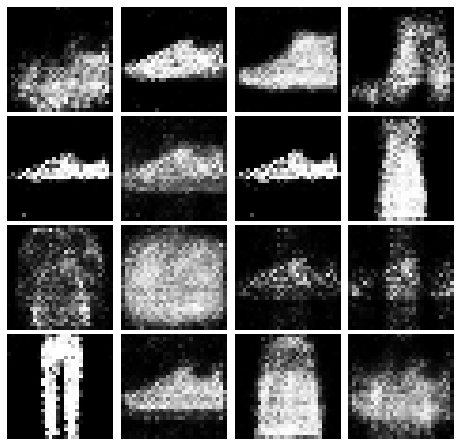

Epoch: 53 / 100 Losses: 
Discriminator: 0.6205 | Generator 2.5540
D(x): 0.7906 | D(G(z)): 0.1620


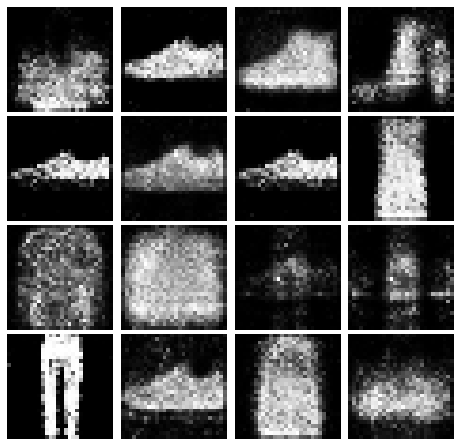

Epoch: 54 / 100 Losses: 
Discriminator: 0.5643 | Generator 2.4815
D(x): 0.8197 | D(G(z)): 0.1888


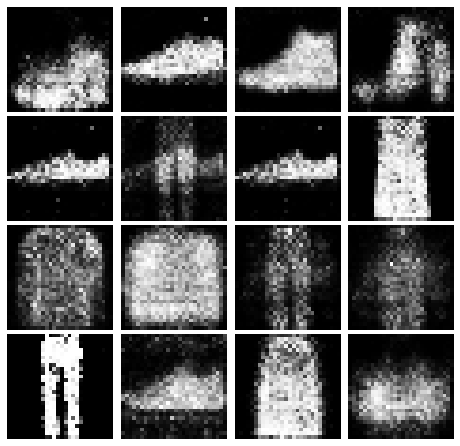

Epoch: 55 / 100 Losses: 
Discriminator: 0.6489 | Generator 2.5804
D(x): 0.7351 | D(G(z)): 0.1147


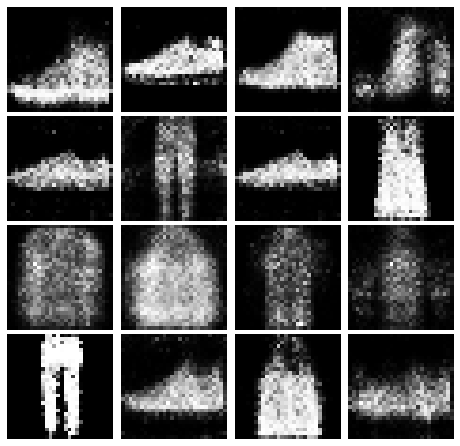

Epoch: 56 / 100 Losses: 
Discriminator: 0.6460 | Generator 2.6686
D(x): 0.8677 | D(G(z)): 0.2938


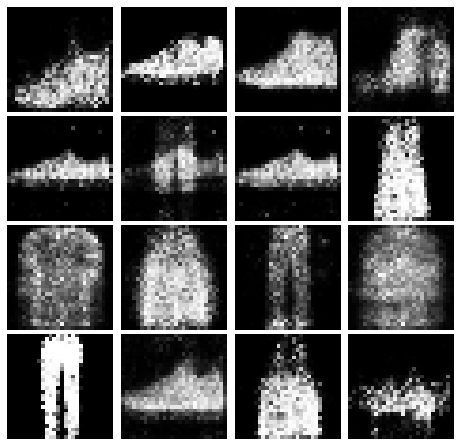

Epoch: 57 / 100 Losses: 
Discriminator: 0.5290 | Generator 2.3968
D(x): 0.8450 | D(G(z)): 0.2128


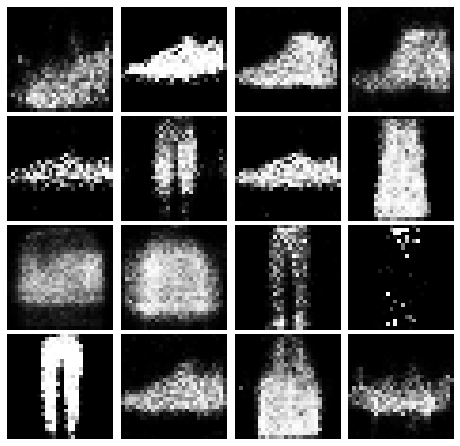

Epoch: 58 / 100 Losses: 
Discriminator: 0.7102 | Generator 3.5322
D(x): 0.8658 | D(G(z)): 0.2961


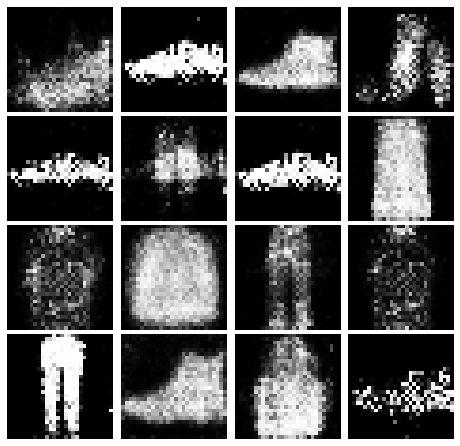

Epoch: 59 / 100 Losses: 
Discriminator: 0.8526 | Generator 2.2595
D(x): 0.7630 | D(G(z)): 0.2344


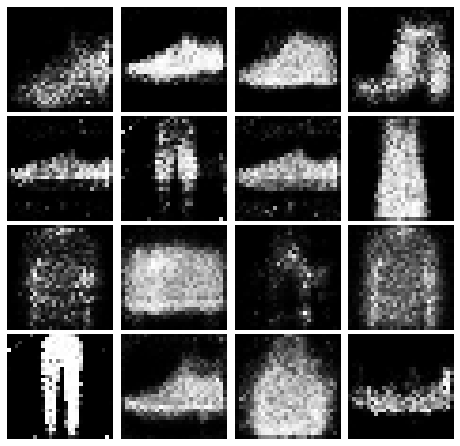

Epoch: 60 / 100 Losses: 
Discriminator: 0.5161 | Generator 2.4293
D(x): 0.8303 | D(G(z)): 0.1461


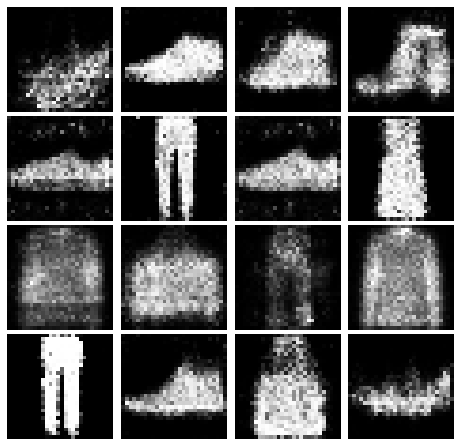

Epoch: 61 / 100 Losses: 
Discriminator: 0.5944 | Generator 2.6271
D(x): 0.7963 | D(G(z)): 0.1405


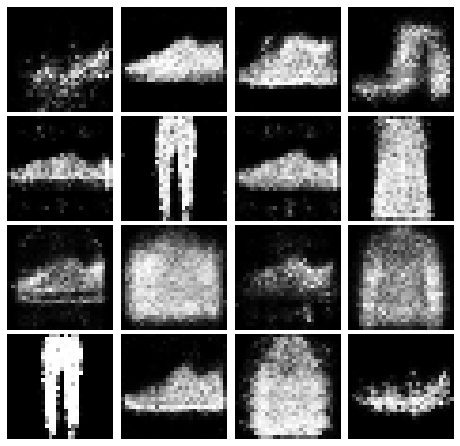

Epoch: 62 / 100 Losses: 
Discriminator: 0.6528 | Generator 1.8129
D(x): 0.8443 | D(G(z)): 0.2622


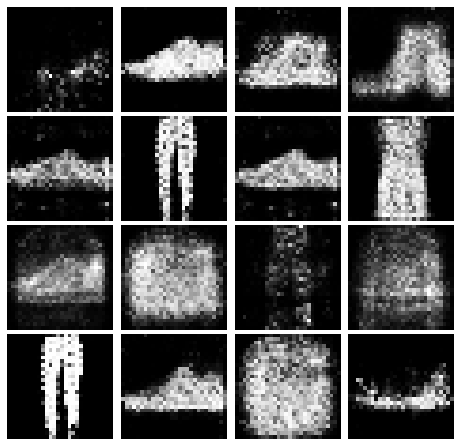

Epoch: 63 / 100 Losses: 
Discriminator: 0.7743 | Generator 2.5560
D(x): 0.8536 | D(G(z)): 0.2830


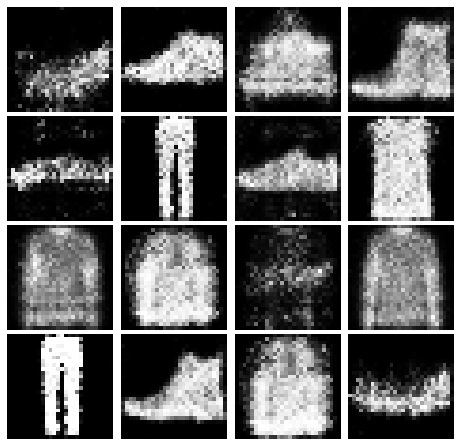

Epoch: 64 / 100 Losses: 
Discriminator: 0.7200 | Generator 1.8830
D(x): 0.7868 | D(G(z)): 0.2730


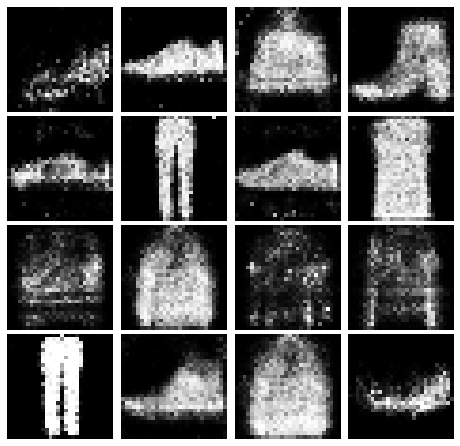

Epoch: 65 / 100 Losses: 
Discriminator: 1.0425 | Generator 2.0658
D(x): 0.7783 | D(G(z)): 0.2874


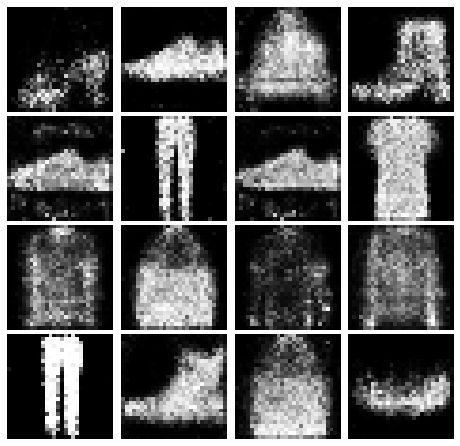

Epoch: 66 / 100 Losses: 
Discriminator: 0.9274 | Generator 1.6093
D(x): 0.7558 | D(G(z)): 0.3563


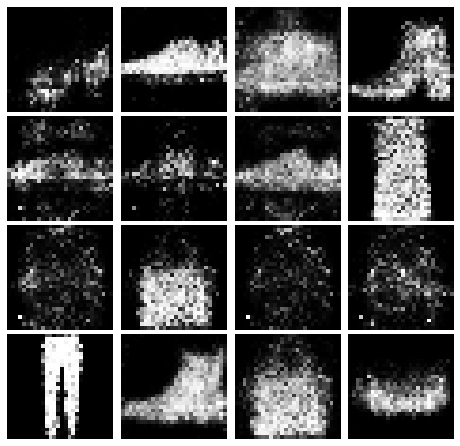

Epoch: 67 / 100 Losses: 
Discriminator: 0.7294 | Generator 2.0977
D(x): 0.7689 | D(G(z)): 0.2088


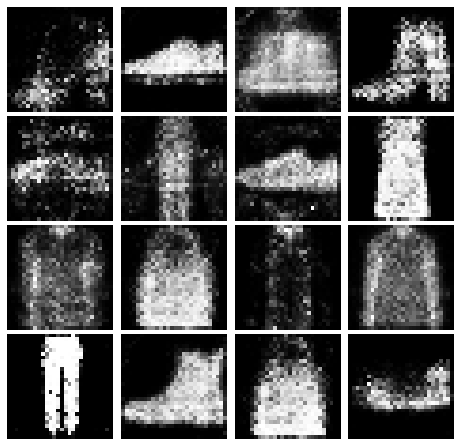

Epoch: 68 / 100 Losses: 
Discriminator: 0.6002 | Generator 2.5878
D(x): 0.8064 | D(G(z)): 0.1727


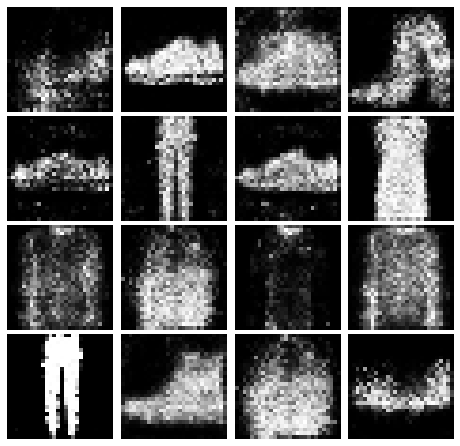

Epoch: 69 / 100 Losses: 
Discriminator: 0.5390 | Generator 2.2527
D(x): 0.7854 | D(G(z)): 0.1277


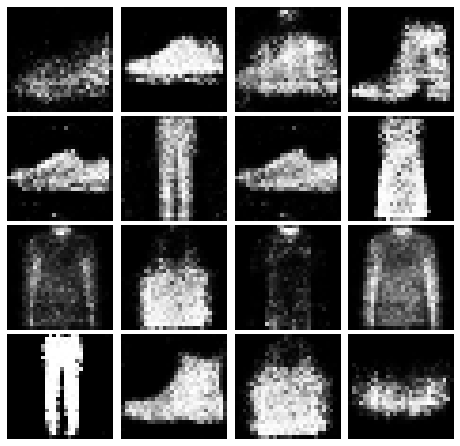

Epoch: 70 / 100 Losses: 
Discriminator: 0.4928 | Generator 2.5806
D(x): 0.8196 | D(G(z)): 0.1168


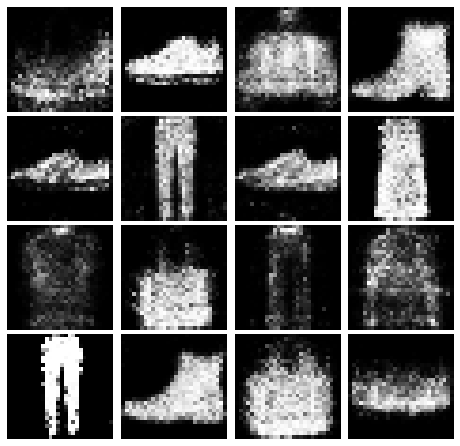

Epoch: 71 / 100 Losses: 
Discriminator: 0.7324 | Generator 1.9115
D(x): 0.7312 | D(G(z)): 0.2003


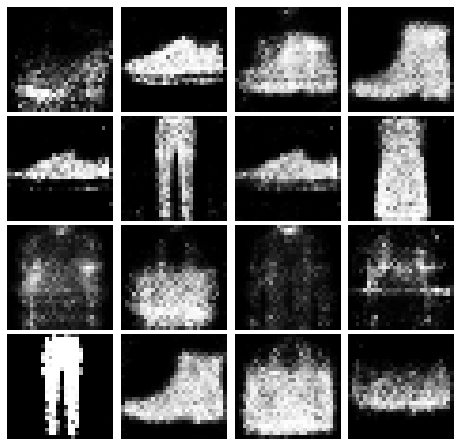

Epoch: 72 / 100 Losses: 
Discriminator: 0.5919 | Generator 1.5402
D(x): 0.8557 | D(G(z)): 0.2793


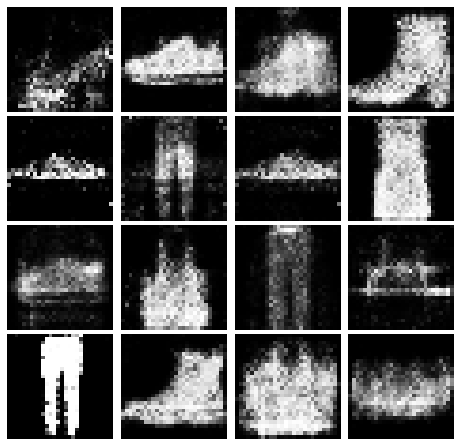

Epoch: 73 / 100 Losses: 
Discriminator: 0.9706 | Generator 1.8103
D(x): 0.7313 | D(G(z)): 0.3383


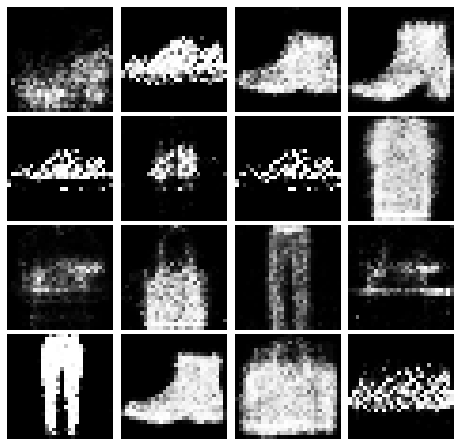

Epoch: 74 / 100 Losses: 
Discriminator: 1.2306 | Generator 4.7447
D(x): 0.6095 | D(G(z)): 0.1474


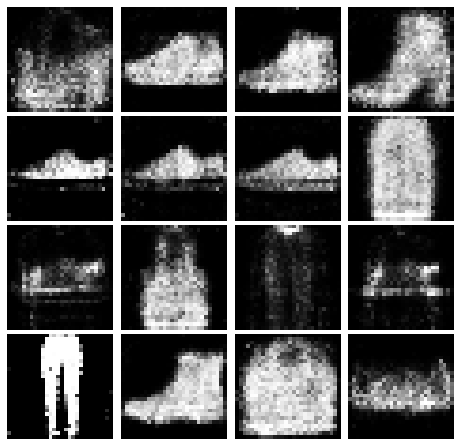

Epoch: 75 / 100 Losses: 
Discriminator: 0.6304 | Generator 2.3730
D(x): 0.8047 | D(G(z)): 0.2275


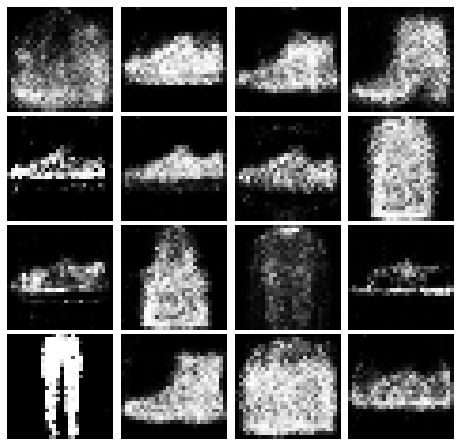

Epoch: 76 / 100 Losses: 
Discriminator: 0.5379 | Generator 2.4013
D(x): 0.8314 | D(G(z)): 0.2216


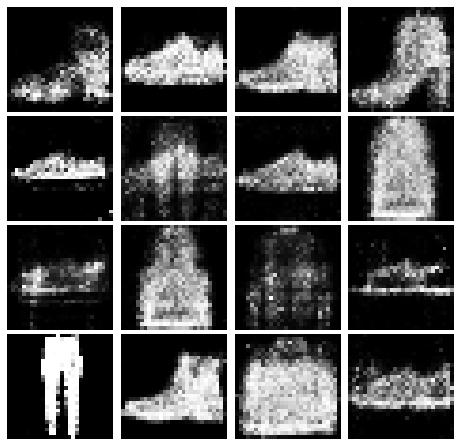

Epoch: 77 / 100 Losses: 
Discriminator: 0.8466 | Generator 1.9761
D(x): 0.7016 | D(G(z)): 0.2247


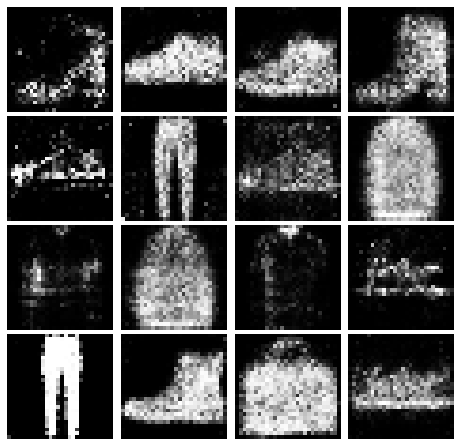

Epoch: 78 / 100 Losses: 
Discriminator: 0.5314 | Generator 2.3009
D(x): 0.7848 | D(G(z)): 0.1625


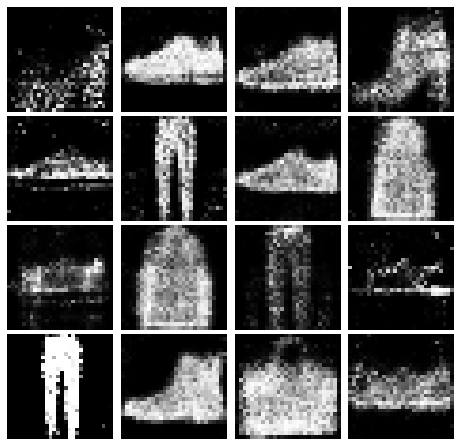

Epoch: 79 / 100 Losses: 
Discriminator: 0.9019 | Generator 1.2813
D(x): 0.6598 | D(G(z)): 0.1903


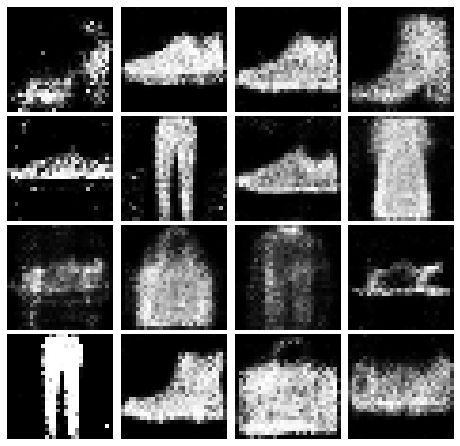

Epoch: 80 / 100 Losses: 
Discriminator: 0.9034 | Generator 2.7898
D(x): 0.6805 | D(G(z)): 0.1661


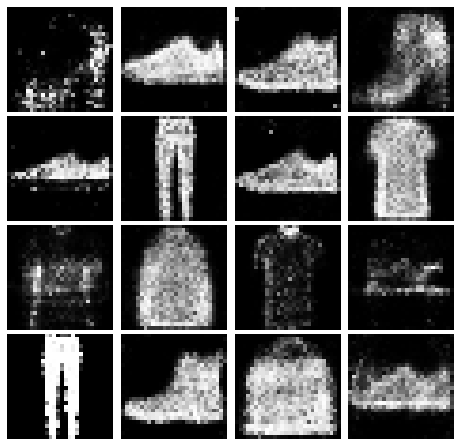

Epoch: 81 / 100 Losses: 
Discriminator: 0.9187 | Generator 1.6720
D(x): 0.7598 | D(G(z)): 0.3767


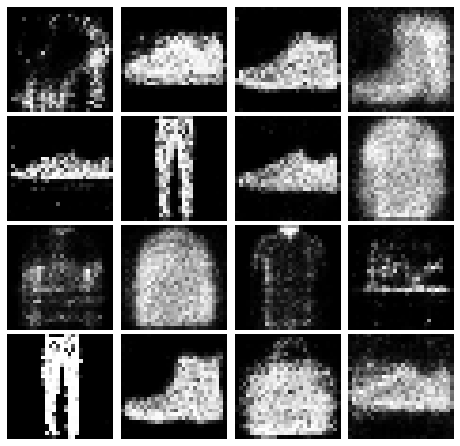

Epoch: 82 / 100 Losses: 
Discriminator: 0.7167 | Generator 1.7111
D(x): 0.7635 | D(G(z)): 0.2705


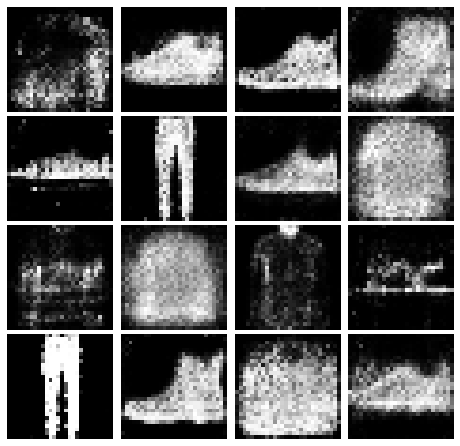

Epoch: 83 / 100 Losses: 
Discriminator: 0.7665 | Generator 1.7288
D(x): 0.7556 | D(G(z)): 0.2943


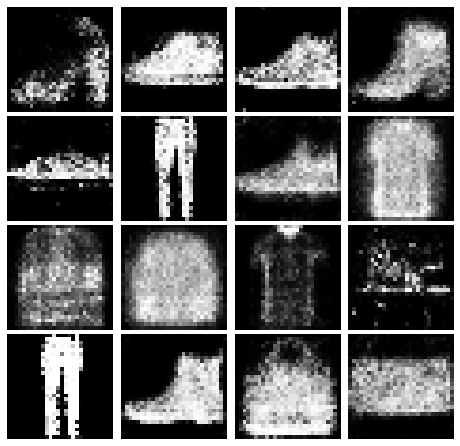

Epoch: 84 / 100 Losses: 
Discriminator: 0.8012 | Generator 2.5623
D(x): 0.7593 | D(G(z)): 0.2465


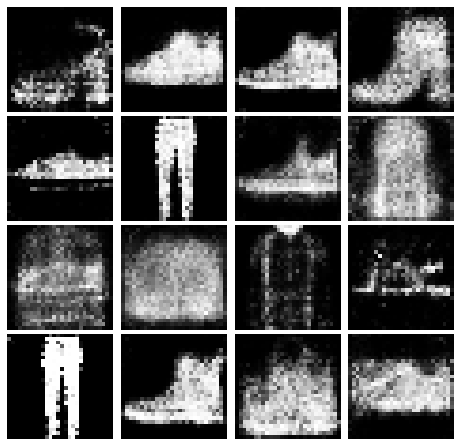

Epoch: 85 / 100 Losses: 
Discriminator: 0.8149 | Generator 1.9701
D(x): 0.6906 | D(G(z)): 0.2152


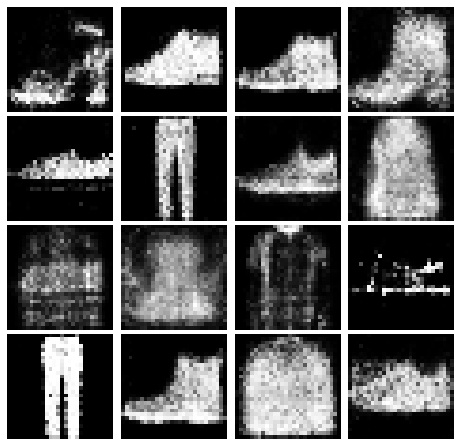

Epoch: 86 / 100 Losses: 
Discriminator: 0.6072 | Generator 1.6867
D(x): 0.8151 | D(G(z)): 0.2707


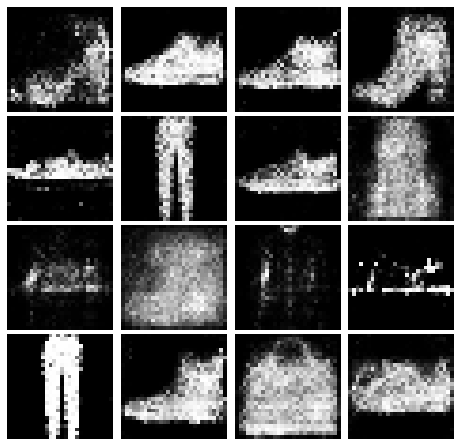

Epoch: 87 / 100 Losses: 
Discriminator: 1.1798 | Generator 2.7760
D(x): 0.7016 | D(G(z)): 0.2878


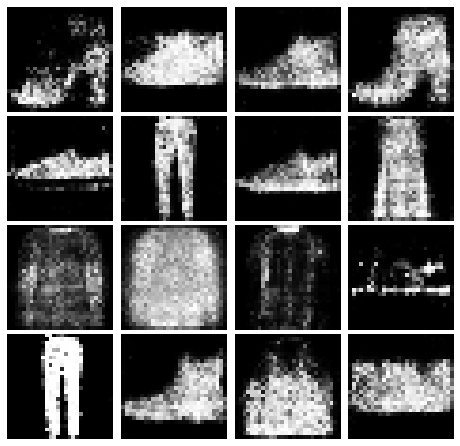

Epoch: 88 / 100 Losses: 
Discriminator: 0.7290 | Generator 1.8504
D(x): 0.7311 | D(G(z)): 0.2111


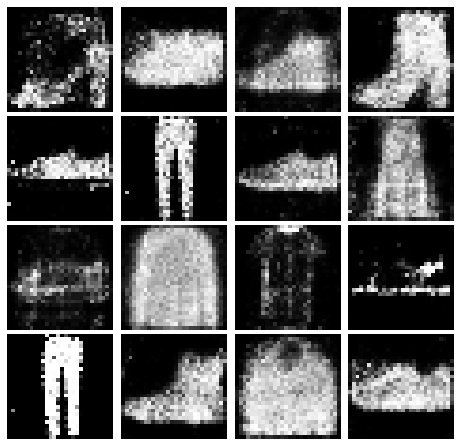

Epoch: 89 / 100 Losses: 
Discriminator: 0.7115 | Generator 2.4070
D(x): 0.8420 | D(G(z)): 0.2453


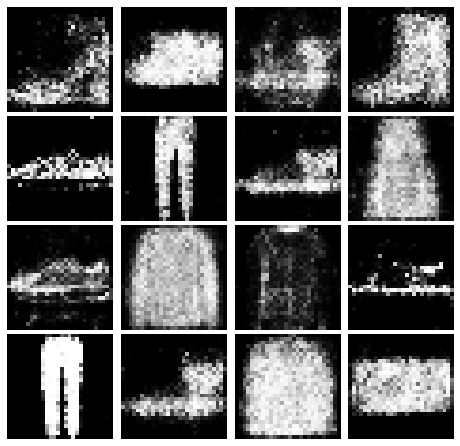

Epoch: 90 / 100 Losses: 
Discriminator: 0.6823 | Generator 3.1593
D(x): 0.8489 | D(G(z)): 0.2260


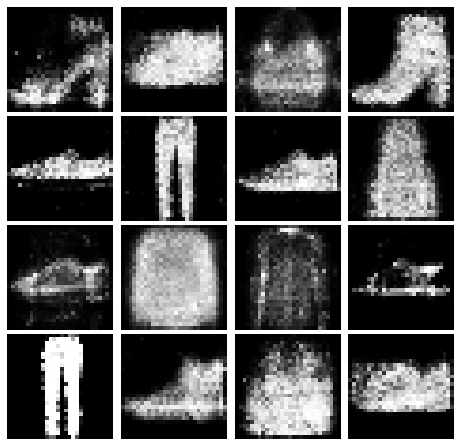

Epoch: 91 / 100 Losses: 
Discriminator: 0.6265 | Generator 1.7552
D(x): 0.8510 | D(G(z)): 0.2566


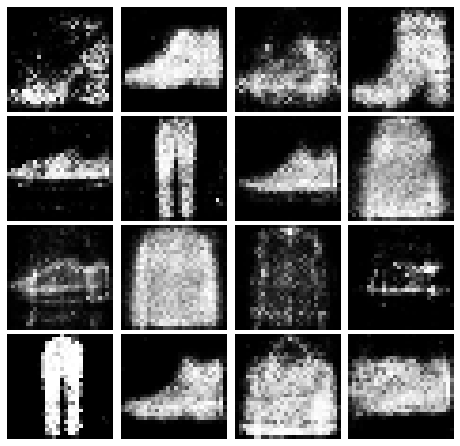

Epoch: 92 / 100 Losses: 
Discriminator: 0.8720 | Generator 2.4725
D(x): 0.7609 | D(G(z)): 0.2395


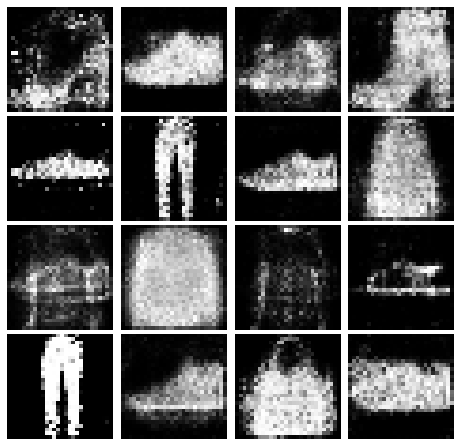

Epoch: 93 / 100 Losses: 
Discriminator: 0.9833 | Generator 2.1805
D(x): 0.6951 | D(G(z)): 0.1591


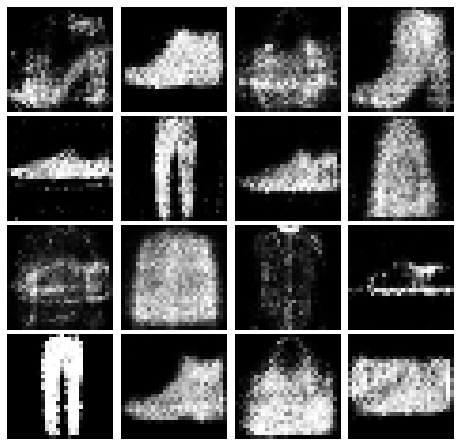

Epoch: 94 / 100 Losses: 
Discriminator: 0.9226 | Generator 1.6849
D(x): 0.7108 | D(G(z)): 0.2488


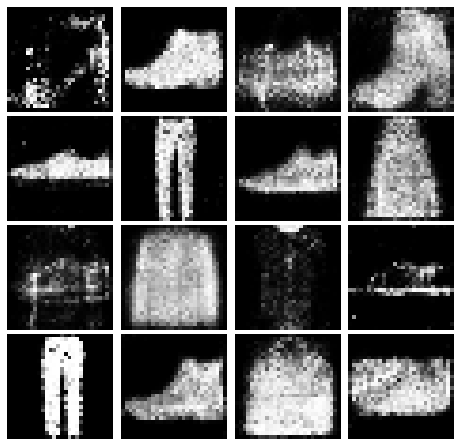

Epoch: 95 / 100 Losses: 
Discriminator: 0.7691 | Generator 2.0143
D(x): 0.7651 | D(G(z)): 0.2438


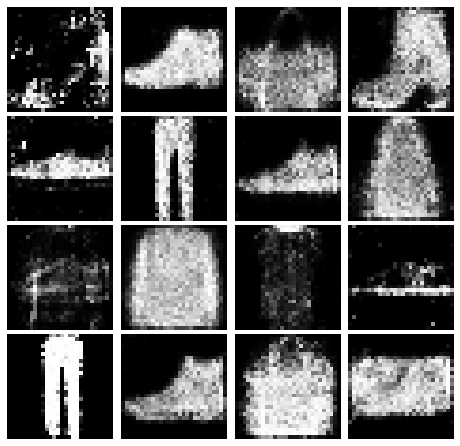

Epoch: 96 / 100 Losses: 
Discriminator: 0.4764 | Generator 3.2615
D(x): 0.8365 | D(G(z)): 0.1599


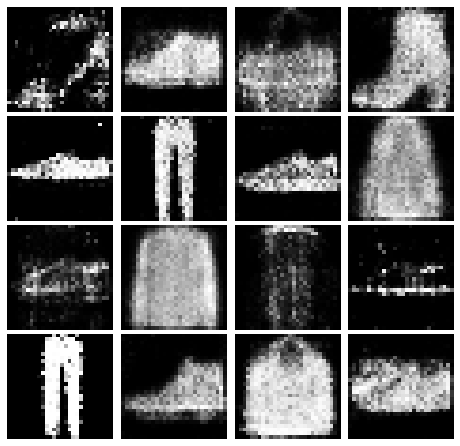

Epoch: 97 / 100 Losses: 
Discriminator: 0.7130 | Generator 2.3991
D(x): 0.8116 | D(G(z)): 0.2261


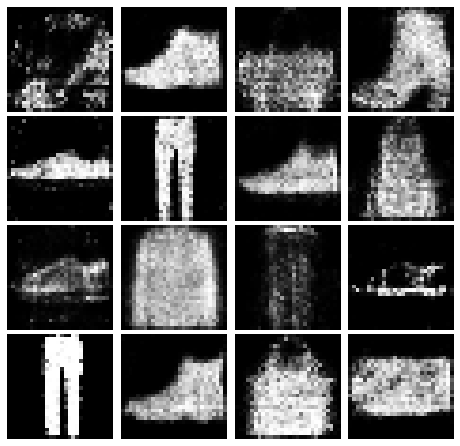

Epoch: 98 / 100 Losses: 
Discriminator: 0.9493 | Generator 2.2785
D(x): 0.6809 | D(G(z)): 0.1866


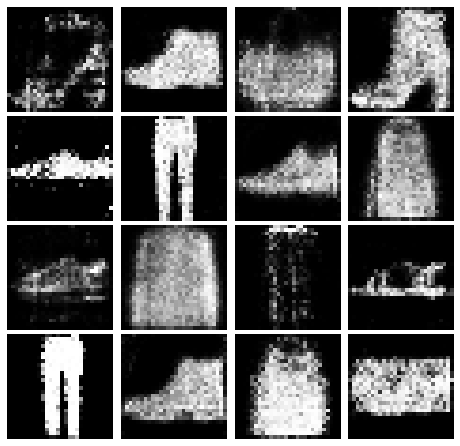

Epoch: 99 / 100 Losses: 
Discriminator: 0.7585 | Generator 2.2227
D(x): 0.7381 | D(G(z)): 0.2166


In [ ]:
# instanciando o número de épocas para o treino
num_epochs = 100

# lista para salvar os erros do gerador e do discriminador
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for realbatch, _ in dataloader:

        real_data = images_to_vectors(realbatch).to(device)

        fake_data = generator(
            noise(real_data.size(0)))

        d_error, dpred_real, dpred_fake = (
            train_discriminator(d_optimizer, 
                                real_data, 
                                fake_data))
        
        fake_data = generator(noise(realbatch.size(0)))
        
        g_error = train_generator(g_optimizer, 
                                  fake_data)
        
    imagepath = os.path.join(IMG_DIR, 
                             f'{epoch + 1}.jpg')
    
    test_images = vectors_to_images(
        generator(test_noise)).cpu().detach().numpy()

    log_images(test_images, imagepath)

    G_losses.append(g_error)
    D_losses.append(d_error)

    print(f'Epoch: {epoch} / {num_epochs} Losses: ')
    print(f'Discriminator: {d_error:.4f} | Generator {g_error:.4f}')
    print(f'D(x): {dpred_real.mean():.4f} | D(G(z)): {dpred_fake.mean():.4f}')

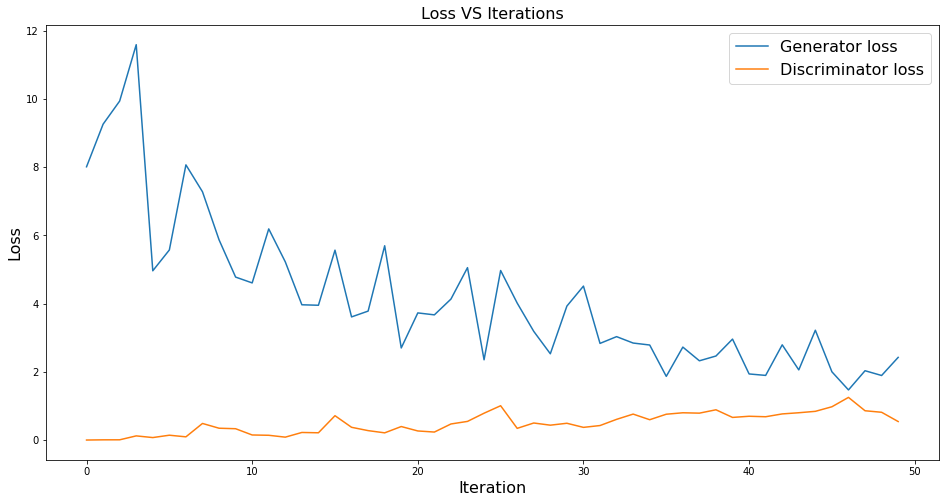

In [ ]:
# função para visualizar os erros do gerador e do discriminador
def plot_losses(losses):
    fig = plt.figure(figsize=[16, 8])
    ax = fig.gca()

    for loss_name, loss_values in losses.items():
        loss_values = [k.item() for k in loss_values]
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss VS Iterations', fontsize='16')

plot_losses({
    'Generator loss': G_losses, 
    'Discriminator loss': D_losses
});